In [1]:
# Data Manipulation 
import numpy as np
import pandas as pd

# Visualization 
import matplotlib.pyplot as plt
import missingno
import seaborn as sns

# Managing Warnings 
import warnings
warnings.filterwarnings('ignore')

# Plot the Figures Inline
%matplotlib inline


# 1. 背景介绍

### 泰坦尼克号于1909年3月31日在爱尔兰动工建造，1911年5月31日下水，次年4月2日完工试航。她是当时世界上体积最庞大、内部设施最豪华的客运轮船，有“永不沉没”的美誉。然而讽刺的是，泰坦尼克号首航便遭遇厄运：1912年4月10日, 她从英国南安普顿(**Southampton**)出发，途径法国瑟堡(Cherbourg)和爱尔兰昆士敦(**Queenston**)，驶向美国纽约。在14日晚23时40分左右，泰坦尼克号与一座冰山相撞，导致船体裂缝进水。次日凌晨2时20分左右，泰坦尼克号断为两截后沉入大西洋，其搭载的2224名船员及乘客，在本次海难中逾1500人丧生。

### 在学习机器学习相关项目时，Titanic生存率预测项目也通常是入门练习的经典案例。Kaggle平台为我们提供了一个竞赛案例“Titanic: Machine Learning from Disaster”，在该案例中，我们将探究什么样的人在此次海难中幸存的几率更高，并通过构建预测模型来预测乘客生存率。

### 本文通过数据可视化理解数据，并利用特征工程等方法挖掘更多有价值的特征，然后利用同组效应找出共性较强的群体并对其数据进行修正，在选择模型时，我发现许多kaggler都是使用了多种传统机器学习交叉验证以及结合模型融合来进行预测，本文则另辟蹊径，选择神经网络来尝试比较于大多数高分kaggler 0.83的准确率。

# 2.数据预处理

### 本文数据集是来源于Kaggle平台中“Titanic: Machine Learning from Disaster”竞赛项目，数据字段释义如下
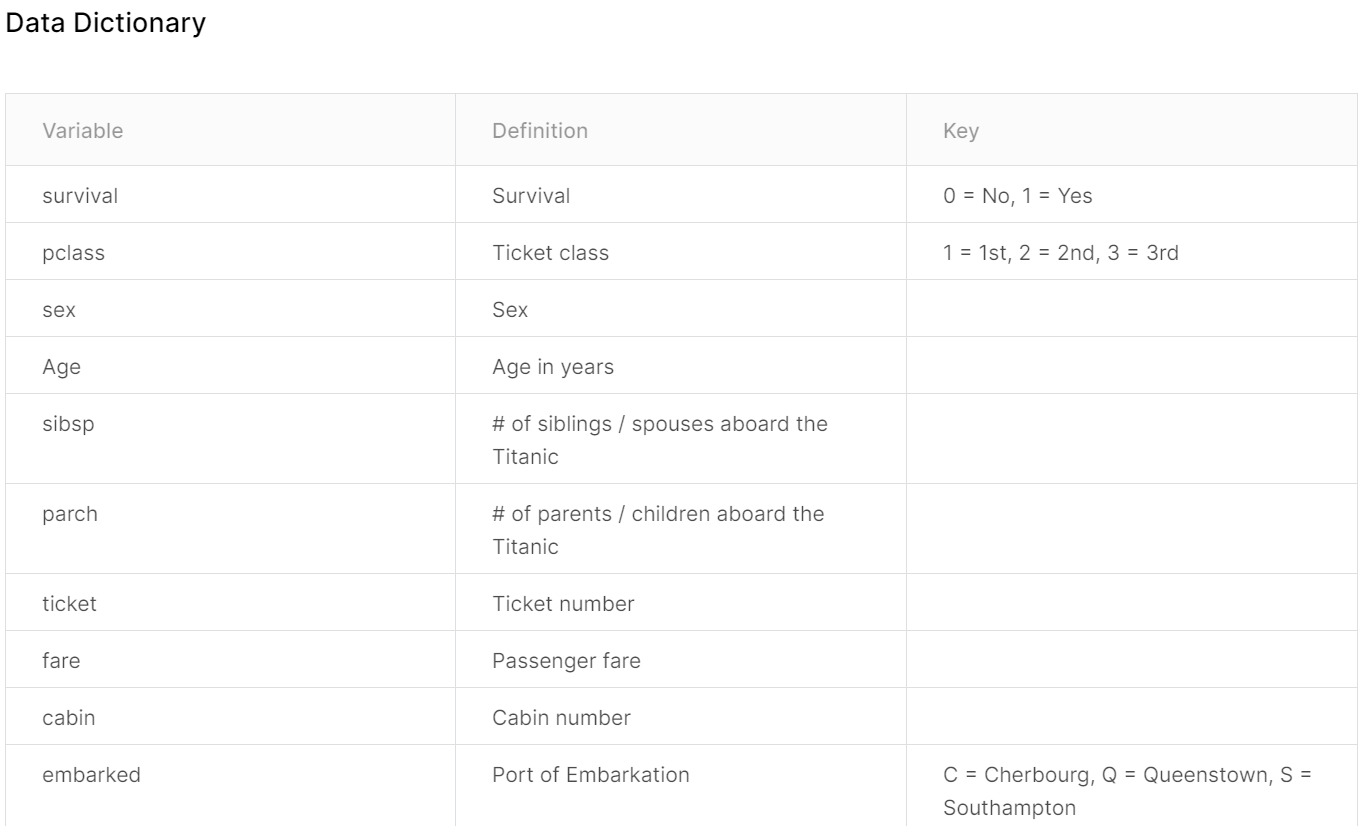

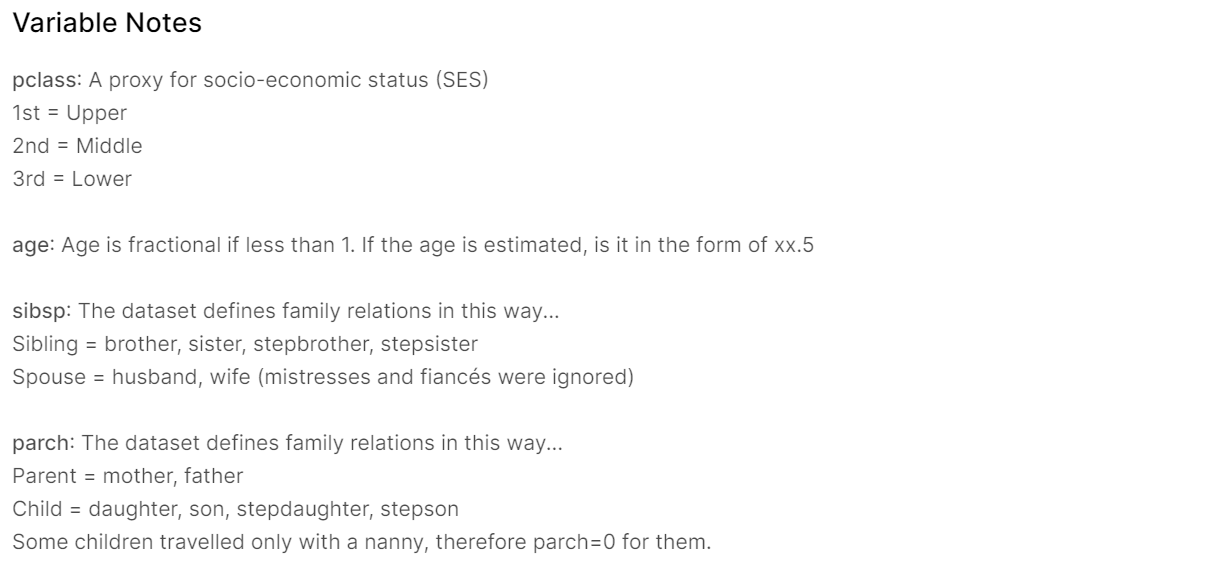

## 2.1 导入数据

In [2]:
df_train=pd.read_csv('../input/titanic/train.csv')
df_test=pd.read_csv('../input/titanic/test.csv')

In [3]:
df_all = pd.concat([df_train, df_test]).reset_index(drop=True)
df_all.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


In [4]:
# 展示所有种类型特征
df_all.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,1309,1309,1309,295,1307
unique,1307,2,929,186,3
top,"Connolly, Miss. Kate",male,CA. 2343,C23 C25 C27,S
freq,2,843,11,6,914


In [5]:
df_all.info()
df_all.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 粗略观察数据

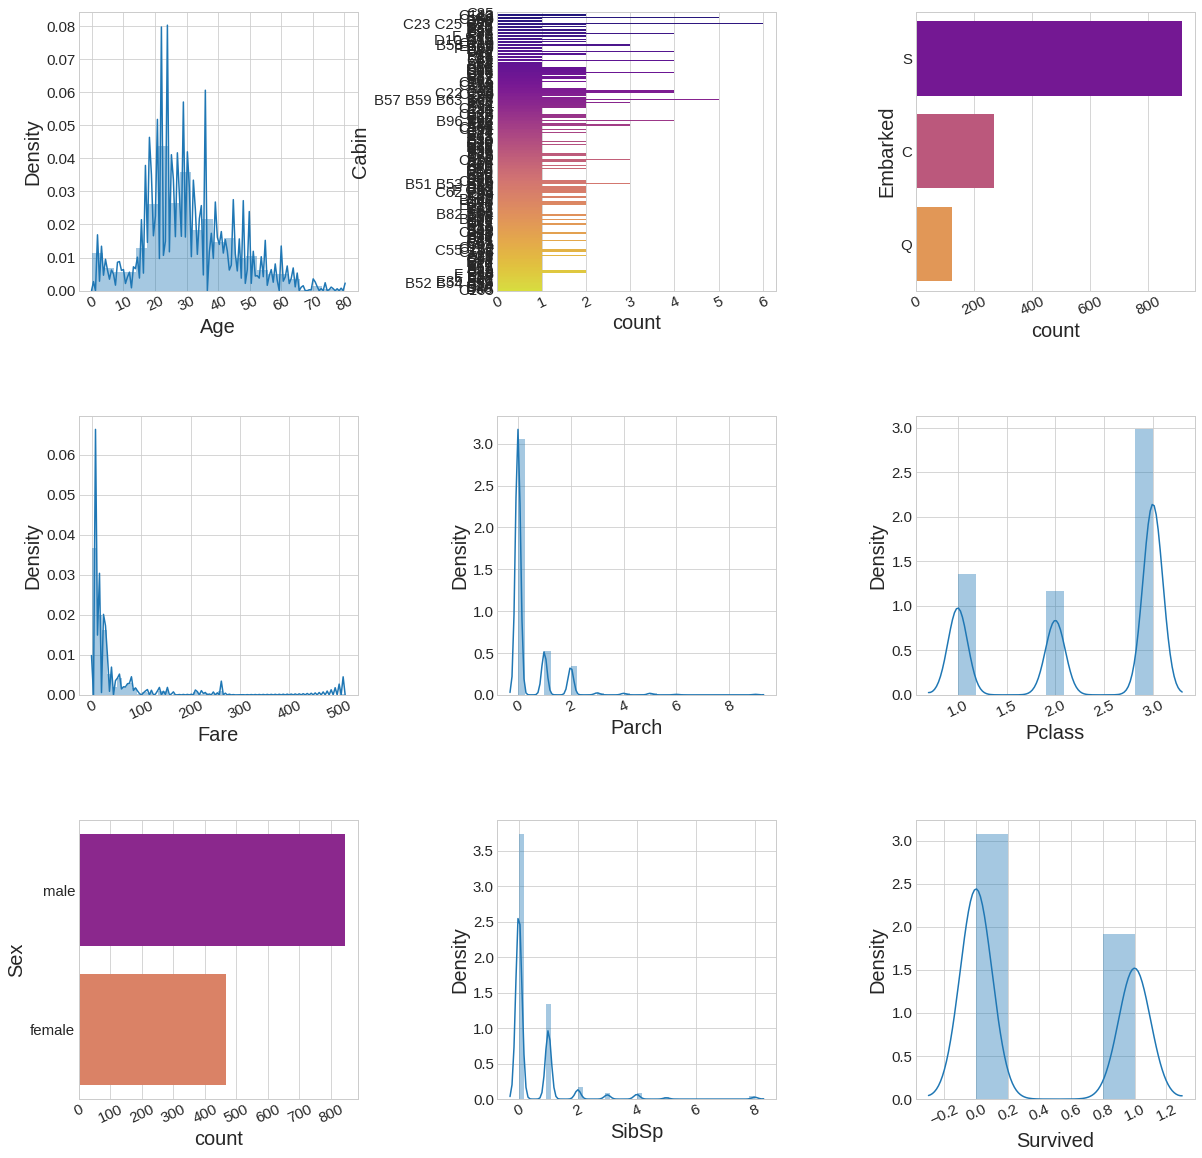

In [6]:
# 单特征展示Have a glance at data
import math
def plot_distribution(dataset, cols=5, width=20, height=15, hspace=0.2, wspace=0.5):
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(width,height))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    rows = math.ceil(float(dataset.shape[1]) / cols)

    for i, column in enumerate(dataset.columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        #ax.set_title(column)
        plt.xlabel(column, fontsize=20)
        plt.ylabel('',fontsize=20)
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        if dataset.dtypes[column] == np.object:
            g = sns.countplot(y=column, data=dataset,palette='plasma')
            plt.xticks(rotation=25)
        else:
            #直方图，频数
            
            g = sns.distplot(dataset[column],kde_kws={'bw': 0.1})
            plt.ylabel(ylabel='Density',fontsize=20)
            plt.xticks(rotation=25)
            
    
plot_distribution(df_all[['Age','Cabin','Embarked','Fare','Parch','Pclass','Sex','SibSp','Survived']], cols=3, width=20, height=20, hspace=0.45, wspace=0.5)

### 查看在不同获救情况下，性别与年龄之间的关系

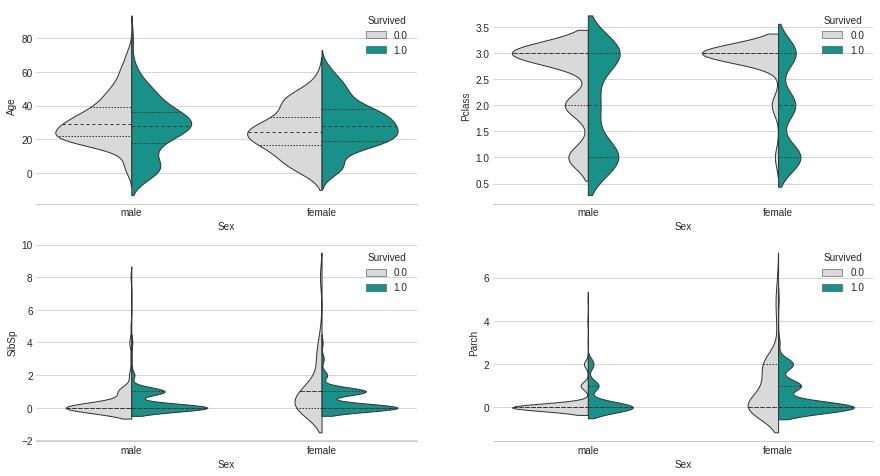

In [7]:
fig = plt.figure(figsize=(15,8))
plt.subplot(2,2,1)
sns.violinplot(data=df_all, x="Sex", y="Age", hue="Survived",
               split=True, inner="quart", linewidth=1,
               palette={1: "#04A699", 0: ".85"})
sns.despine(left=True)
plt.subplot(2,2,2)
sns.violinplot(data=df_all, x="Sex", y="Pclass", hue="Survived",
               split=True, inner="quart", linewidth=1,
               palette={1: "#04A699", 0: ".85"})
sns.despine(left=True)
plt.subplot(2,2,3)
sns.violinplot(data=df_all, x="Sex", y="SibSp", hue="Survived",
               split=True, inner="quart", linewidth=1,
               palette={1: "#04A699", 0: ".85"})
sns.despine(left=True)
plt.subplot(2,2,4)
sns.violinplot(data=df_all, x="Sex", y="Parch", hue="Survived",
               split=True, inner="quart", linewidth=1,
               palette={1: "#04A699", 0: ".85"})
sns.despine(left=True)

由上图可以得出以下结论：1. 不同生存情况下，男女性别在年龄分布中相似。2. 不同舱位生存比例不一，男女各舱位分布相似。3. 女性获救乘员中，兄弟姐妹的影响似乎很大。

### 因此，下面我们着重看一下Pclass与生存的关系

### Pclass和生存率

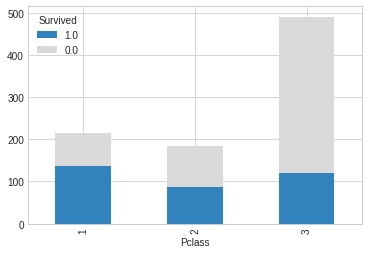

In [8]:
s_pclass= df_all['Survived'].groupby(df_all['Pclass'])
s_pclass = s_pclass.value_counts().unstack()
s_pclass= s_pclass[[1.0,0.0]]
s_pclass.plot(kind='bar',stacked = True, colormap='tab20c')

*很显然，lower class的乘客死亡率较高*

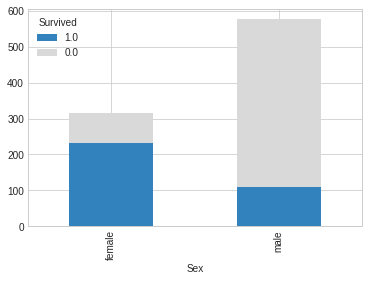

In [9]:
s_sex = df_all['Survived'].groupby(df_all['Sex'])
s_sex = s_sex.value_counts().unstack()
s_sex = s_sex[[1.0,0.0]]
ax = s_sex.plot(kind='bar',stacked=True,colormap='tab20c')

*男性乘客幸存率远小于女性，窥见lady-first原则*

综合性别和舱位两个变量来观察对生存率的影响

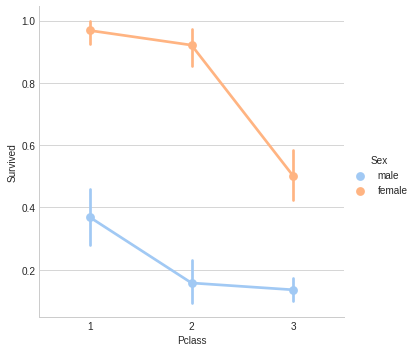

In [10]:
sns.catplot(x="Pclass",y='Survived', hue="Sex", kind="point",
            palette="pastel", edgecolor=".6",
            data=df_all)

*可见，性别和舱位对生存的影响很大，特别是性别*

## 缺失值显示

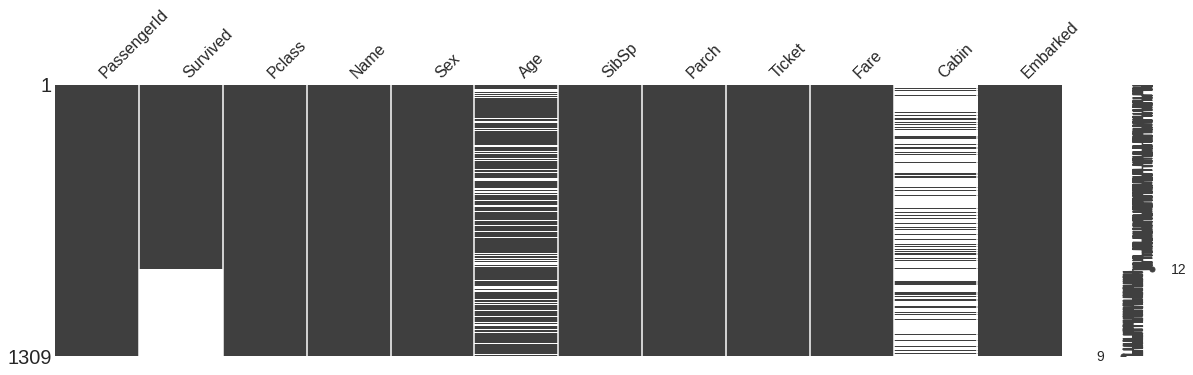

In [11]:

missingno.matrix(df_all, figsize = (20,5))

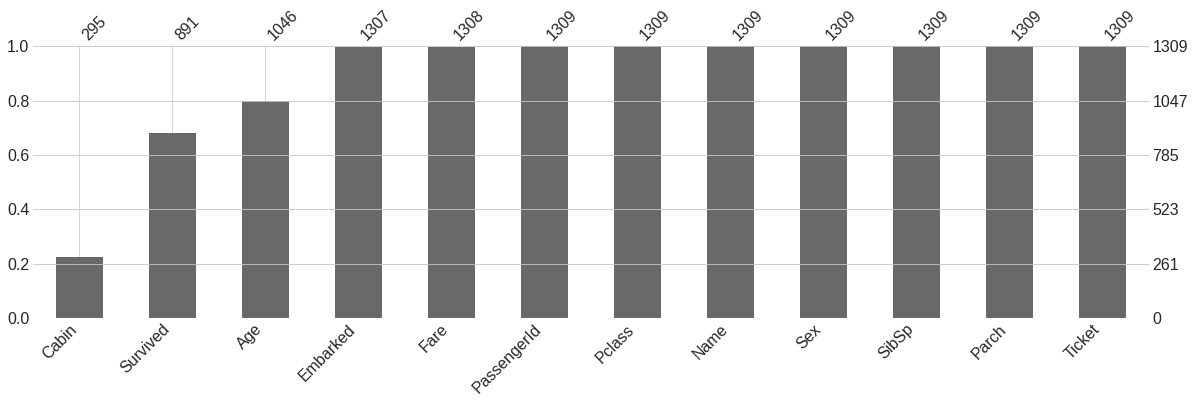

In [12]:
missingno.bar(df_all, sort='ascending', figsize = (20,5))

## 2.1 数据清洗

### 2.1.1 处理Emabarked缺失值

In [13]:
# 通过谷歌搜索唯二的两个乘客名字，可以得知登陆港口信息，不过这里我是引用gunesevitan的结论
df_all['Embarked'] = df_all['Embarked'].fillna('S')
df_all['Embarked'].head()

0    S
1    C
2    S
3    S
4    S
Name: Embarked, dtype: object

### 2.1.2 处理Cabin缺失值

In [14]:
#对Cabin缺失值进行处理，利用U（Unknown）填充缺失值
df_all['Cabin']=df_all['Cabin'].fillna('U')
df_all['Cabin'].head()

0       U
1     C85
2       U
3    C123
4       U
Name: Cabin, dtype: object

### 2.1.3 处理Fare缺失值

In [15]:
#查看缺失值
df_all[df_all['Fare'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1043,1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,U,S


In [16]:
#假设船票价和Cabin,Pclass以及Embarked有关(按照常理推断)
df_all['Fare']=df_all['Fare'].fillna(df_all[(df_all['Pclass']==3)&(df_all['Embarked']=='S')&(df_all['Cabin']=='U')]['Fare'].mean())

### 2.1.4 处理Age缺失值

#### 因为Age项缺失较多，所以不能直接将其填充为众数或者平均数。常见有两种填充法，一是根据Title项中的Mr、Master、Miss等称呼的平均年龄填充，或者综合几项（Sex、Title、Pclass）的Age均值。二是利用其他组特征量，采用机器学习算法来预测Age，本例采用的是第二种方法。

In [17]:
#将Age完整的项作为训练集、将Age缺失的项作为测试集。
missing_age_df = df_all.iloc[:,[1,2,4,5,6,7,8,9,10,11]]
missing_age_df['Sex']= missing_age_df['Sex'].factorize()[0]
missing_age_df['Embarked']= missing_age_df['Embarked'].factorize()[0]
missing_age_df['Cabin']= missing_age_df['Cabin'].factorize()[0]
missing_age_df.corr()['Age'].sort_values(0)

Pclass     -0.408106
SibSp      -0.243699
Parch      -0.150917
Survived   -0.077221
Sex        -0.063645
Embarked    0.047410
Fare        0.177531
Cabin       0.272991
Age         1.000000
Name: Age, dtype: float64

In [18]:
missing_age_df = pd.DataFrame(missing_age_df[['Age', 'Parch','SibSp','Fare', 'Pclass','Cabin']])

In [19]:
#拆分训练集和测试集
age_train=missing_age_df[missing_age_df['Age'].notnull()]
age_test=missing_age_df[missing_age_df['Age'].isnull()]

#生成训练数据的特征和标签
age_train_X=age_train.drop(['Age'],axis=1)
age_train_y=age_train['Age']
#生成测试数据的特征
age_test_X=age_test.drop(['Age'],axis=1)

#利用随机森林构建模型
from sklearn.ensemble import RandomForestRegressor
rfr=RandomForestRegressor(random_state=0, n_estimators=2000, n_jobs=-1)
rfr.fit(age_train_X,age_train_y)

#模型得分
print('模型得分：',rfr.score(age_train_X,age_train_y))

模型得分： 0.6873493620999973


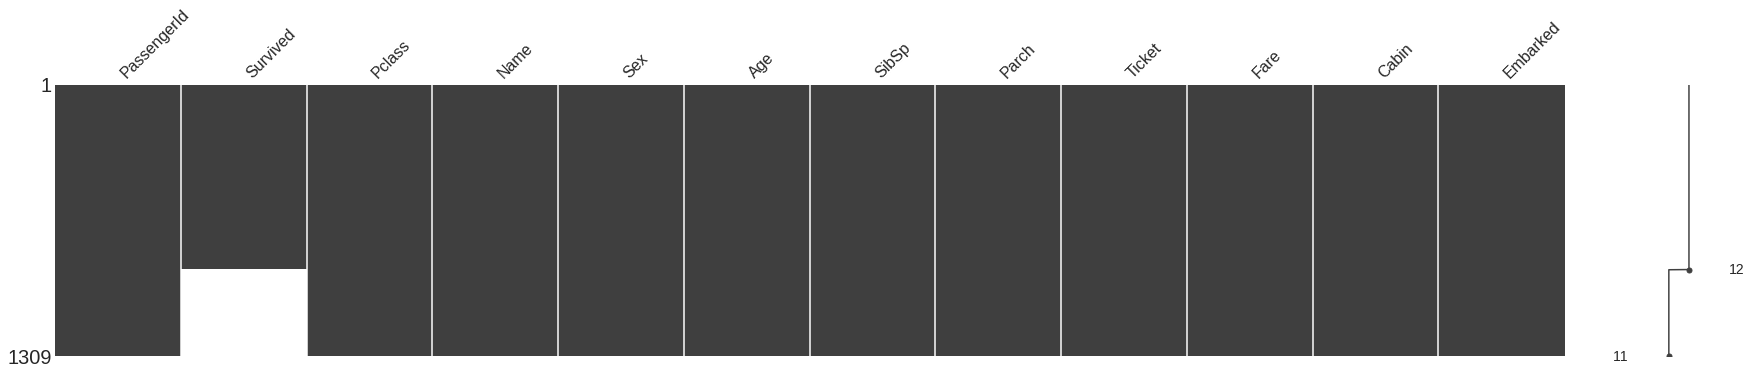

In [20]:
#预测年龄
age_test_y=rfr.predict(age_test_X)
#填充预测数据
df_all.loc[df_all['Age'].isnull(),['Age']]=age_test_y
# 缺失值显示
missingno.matrix(df_all, figsize = (30,5))

*Done with null values.*

填补完age来看一下age对生存的影响

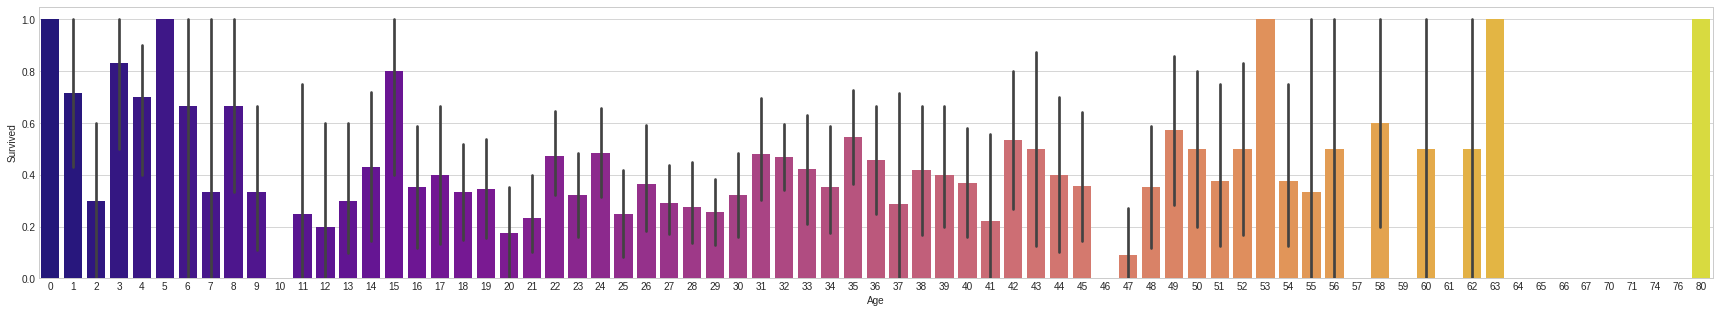

In [21]:
df_all['Age'] = df_all['Age'].astype(int)
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(30,5)) 
sns.barplot(x="Age", y='Survived',data=df_all,palette='plasma');

*影响不是特别大，整体来说，儿童/青少年生存率较大*

# 3. 特征工程

## 3.1 Cabin
由于有大量的缺失值，我们采取二分类的方式进行特征转换

In [22]:
df_all['Cabin'] = df_all['Cabin'].apply(lambda x:x[0])

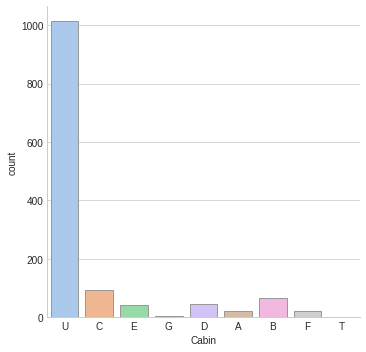

In [23]:
sns.catplot(x="Cabin", kind="count",
            palette="pastel", edgecolor=".6",
            data=df_all)

In [24]:
df_all.loc[ (df_all.Cabin !='U'), 'Cabin' ] = "Yes"
df_all.loc[ (df_all.Cabin =='U'), 'Cabin' ] = "No"

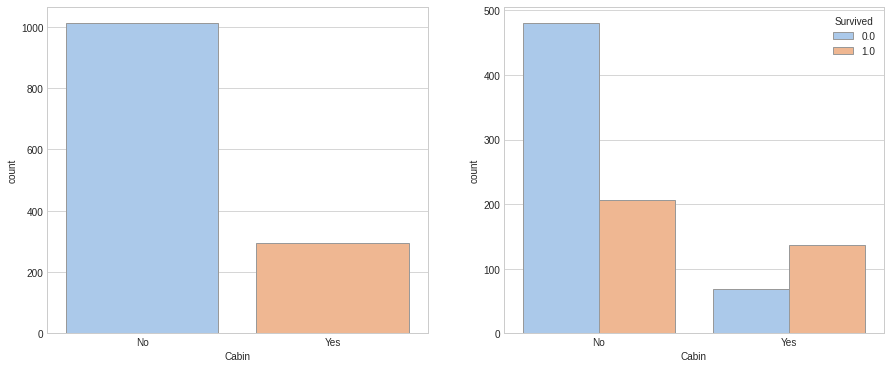

In [25]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(15,6)) 
plt.subplot(1,2,1)
sns.countplot(x="Cabin",
            palette="pastel", edgecolor=".6",
            data=df_all)
plt.subplot(1,2,2)
sns.countplot(x="Cabin", hue="Survived",palette="pastel", edgecolor=".6",
            data=df_all)

*通过对Cabin的二分类，发现有没有Cabin的乘客幸存率是有差异的*

## 3.2 用最简单的模型获取Baseline
由于此前，再没有baseline的情况下进行了大量特征转化和生成新特征，最后我用学习曲线验证发现，模型出现过拟合情况，因此，这一次先做一个基础模型，看LB得分后在进行挖掘。

### 构建虚拟变量

In [26]:
df_base = df_all.iloc[:,1:]
df_base['Sex'] = df_base['Sex'].factorize()[0]
df_base = pd.get_dummies(df_base,columns={'Embarked','Pclass','Cabin'})
df_base.drop(['Name','Ticket'],axis=1,inplace=True)

### 归一化处理

In [27]:
from sklearn.preprocessing import StandardScaler
std_scale = StandardScaler()

## transforming "age"
df_base['Age'] = std_scale.fit_transform(df_base['Age'].values.reshape(-1,1))
## transforming "fare"
df_base['Fare'] = std_scale.fit_transform(df_base['Fare'].values.reshape(-1,1))
df_base.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Cabin_No,Cabin_Yes
0,0.0,0,-0.574120,1,0,-0.503292,0,0,1,0,0,1,1,0
1,1.0,1,0.617119,1,0,0.734743,1,0,0,1,0,0,0,1
2,1.0,1,-0.276310,0,0,-0.490242,0,0,1,0,0,1,1,0
3,1.0,1,0.393762,1,0,0.383183,1,0,0,0,0,1,0,1
4,0.0,0,0.393762,0,0,-0.487825,0,0,1,0,0,1,1,0


### 训练模型（逻辑回归）

In [28]:
#分割训练集和测试集
df_base_train = df_base[df_base['Survived'].notnull()]
df_base_test = df_base[df_base['Survived'].isnull()]

In [29]:
# separating our independent and dependent variable
X_train = df_base_train.drop(['Survived'], axis = 1).astype(float)
y_train = df_base_train["Survived"].astype(float)

X_test = df_base_test.drop(['Survived'], axis = 1).astype(float)

#train model
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(solver='liblinear',C=1.0, penalty='l1', tol=1e-6)
clf.fit(X_train, y_train)

LogisticRegression(penalty='l1', solver='liblinear', tol=1e-06)

### 预测、导出结果

In [30]:
base_pred = clf.predict(X_test)
result = pd.DataFrame({'PassengerId':df_test['PassengerId'].values, 'Survived':base_pred.astype(np.int32)})
result.to_csv("baseline.csv", index=False)
result.head(10)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


### LB得分：

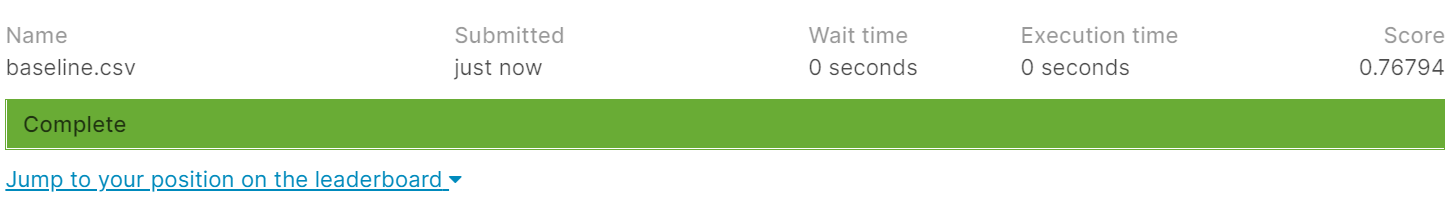

### 学习曲线验证模型

曲线中点： 0.808636815631898 Gap： 0.029843201468851666


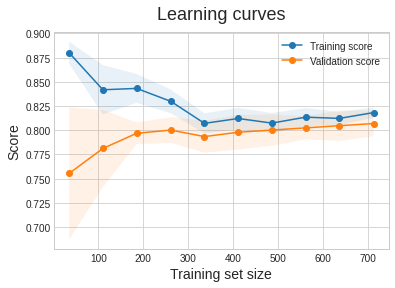

In [31]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, validation_scores = learning_curve(
                                                   estimator = clf, X = X_train,
                                                   y = y_train, train_sizes = np.linspace(.05, 1., 10))
train_scores_mean = train_scores.mean(axis = 1)
validation_scores_mean = validation_scores.mean(axis = 1)
train_scores_std = train_scores.std(axis=1)
validation_scores_std = validation_scores.std(axis=1)

midpoint = ((train_scores_mean[-1] + train_scores_std[-1]) + (validation_scores_mean[-1] - validation_scores_std[-1])) / 2
diff = (train_scores_mean[-1] + train_scores_std[-1]) - (validation_scores_mean[-1] - validation_scores_std[-1])
print("曲线中点：",midpoint,"Gap：",diff)

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std,alpha=0.1)
plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std, validation_scores_mean + validation_scores_std, alpha=0.1)

plt.plot(train_sizes, train_scores_mean,'o-', label = 'Training score')
plt.plot(train_sizes, validation_scores_mean,'o-', label = 'Validation score')

plt.ylabel('Score', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves', fontsize = 18, y = 1.03)
plt.legend()

观察学习曲线发现模型没有过拟合，可以新增更多的特征到模型当中。

## 3.3 继续新增特征

根据逻辑回归算法的文献说明：coef_ corresponds to outcome 1 (True) and -coef_ corresponds to outcome 0 (False).

In [32]:
pd.DataFrame({"columns":list(df_base.columns)[1:], "coef":list(clf.coef_.T)})

,columns,coef
0,Sex,[2.643883231116188]
1,Age,[-0.5570294518736567]
2,SibSp,[-0.3493141663250437]
3,Parch,[-0.10719948171729195]
4,Fare,[0.09030147752933752]
5,Pclass_1,[0.3668613044487335]
6,Pclass_2,[0.0]
7,Pclass_3,[-1.2274972246804468]
8,Embarked_C,[0.0]
9,Embarked_Q,[0.0]


### 尝试：
1. 结合之前age的分析，直接用age作为连续值进行拟合也不太合适，可以进行离散化处理尝试一下。
3. 可以将SibSp、Parch结合生成新的特征familysize
4. 名字中的title和Surname也可以尝试提取

In [33]:
df_improve = df_all.iloc[:,1:]
df_improve.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0.0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,No,S
1,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,Yes,C
2,1.0,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,No,S
3,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,Yes,S
4,0.0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,No,S


## 3.4 Familysize

In [34]:
df_improve['Familysize'] = df_improve['Parch'] + df_improve['SibSp'] 

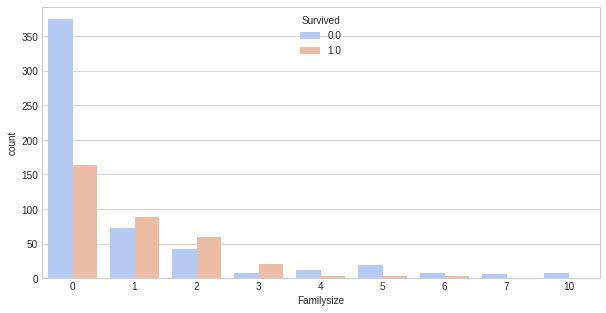

In [35]:
fg = plt.figure(figsize=(10,5))
sns.countplot(x='Familysize',hue='Survived',data=df_improve,palette="coolwarm")

经过观察，以及之前的尝试，这次决定将familysize改成isAlone二分类，而不是像原先binning处理

In [36]:
aloneDiction = {}
aloneDiction[0] = 1
df_improve['isAlone'] = df_improve['Familysize'].map(aloneDiction).fillna(0)

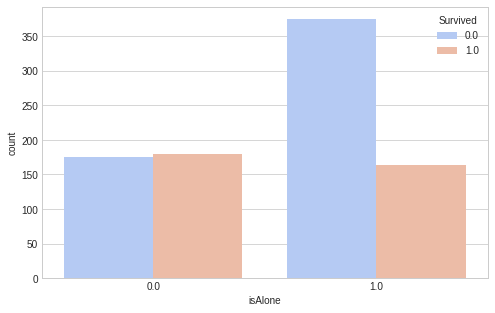

In [37]:
fg = plt.figure(figsize=(8,5))
sns.countplot(x='isAlone',hue='Survived',data=df_improve,palette="coolwarm")

## 3.5 Title

#### 提取Title

In [38]:
df_improve['Title'] = df_improve['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
df_improve['Title'].value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Dr                8
Rev               8
Col               4
Ms                2
Mlle              2
Major             2
Lady              1
Don               1
Sir               1
Mme               1
the Countess      1
Dona              1
Capt              1
Jonkheer          1
Name: Title, dtype: int64

In [39]:
TitleDict={}
TitleDict['Mr']='Man'
TitleDict['Mlle']='Woman'
TitleDict['Miss']='Woman'
TitleDict['Mme']='Woman'
TitleDict['Ms']='Woman'
TitleDict['Mrs']='Woman'
TitleDict['Master']='Boy'
TitleDict['Jonkheer']='Man'
TitleDict['Don']='Man'
TitleDict['Sir']='Man'
TitleDict['the Countess']='Woman'
TitleDict['Dona']='Woman'
TitleDict['Lady']='Woman'
TitleDict['Capt']='Man'
TitleDict['Col']='Man'
TitleDict['Major']='Man'
TitleDict['Dr']='Man'
TitleDict['Rev']='Man'

df_improve['Title']=df_improve['Title'].map(TitleDict)
df_improve['Title'].value_counts()

Man      783
Woman    465
Boy       61
Name: Title, dtype: int64

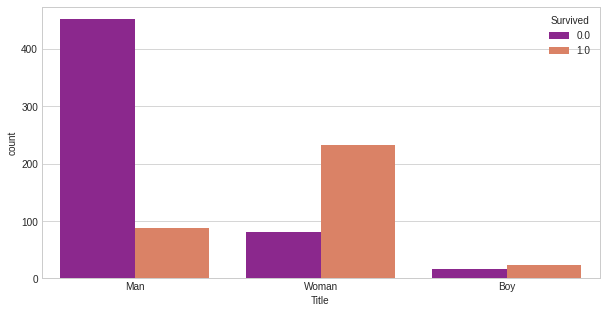

In [40]:
fg = plt.figure(figsize=(10,5))
sns.countplot(x='Title', hue='Survived',data=df_improve,palette="plasma")

可见一斑呀

## 3.6 Age

Text(0.5, 0, 'Age')

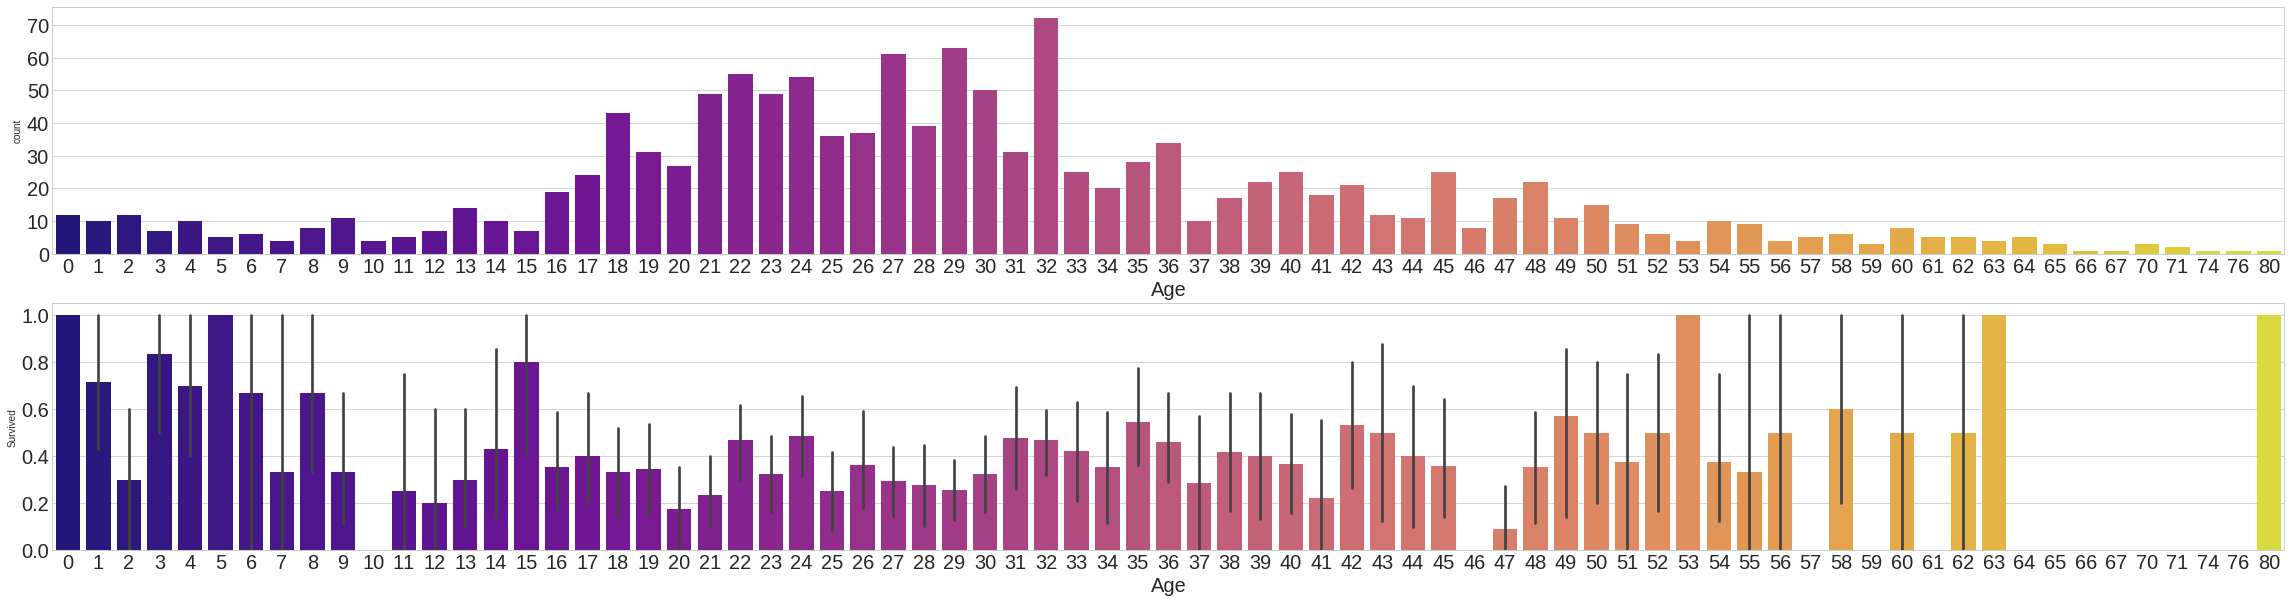

In [41]:
plt.figure(figsize=(40,10))
plt.xticks(rotation=90)
plt.subplot(2,1,1)
sns.countplot(data=df_improve,x='Age',palette='plasma')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Age', fontsize=20)
plt.subplot(2,1,2)
sns.barplot(data=df_improve,x='Age', y='Survived',palette='plasma')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Age', fontsize=20)

经过之前的多次尝试，以及借鉴LR的验证，age无论是作为离散还是连续都不太能提高预测准度，反而成为噪音，但是值得尝试的是，age<16的或者<12这部分人群可作为child单独列为一组或者使用更加取巧的办法——将child和wowen归为一类根据是否幸存来分组。

In [42]:
#提取child年龄段
childGroup = df_improve.loc[df_improve['Age'] <= 12]
childGroup.value_counts('Survived')

Survived
1.0    43
0.0    33
dtype: int64

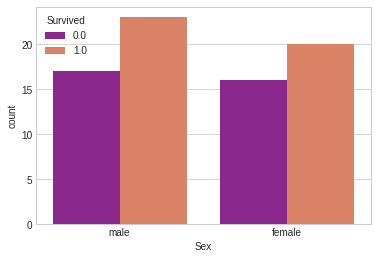

In [43]:
sns.countplot(data=childGroup,x='Sex', hue='Survived',palette='plasma')

将小于12岁的儿童根据是否幸存，来更改他的性格，使整体数据更加符合lady&child first原则

In [44]:
child_female = childGroup[(childGroup['Sex']=='male')& (childGroup['Survived']==1)].index
child_male = childGroup[(childGroup['Sex']=='female')& (childGroup['Survived']==0)].index

In [45]:
df_improve['Sex'][child_female]='female'
df_improve['Sex'][child_male]='male'

## 4.建模

drop不需要的变量

In [46]:
df_improve.drop(['Name','Ticket','SibSp','Parch','Age','Fare'],axis=1,inplace=True)

In [47]:
df_improve['Sex'] = df_improve['Sex'].factorize()[0]
df_improve['Cabin'] = df_improve['Cabin'].factorize()[0]

df_improve = pd.get_dummies(df_improve,columns={'Title','Pclass','Embarked','Familysize'})

### 检查相关性

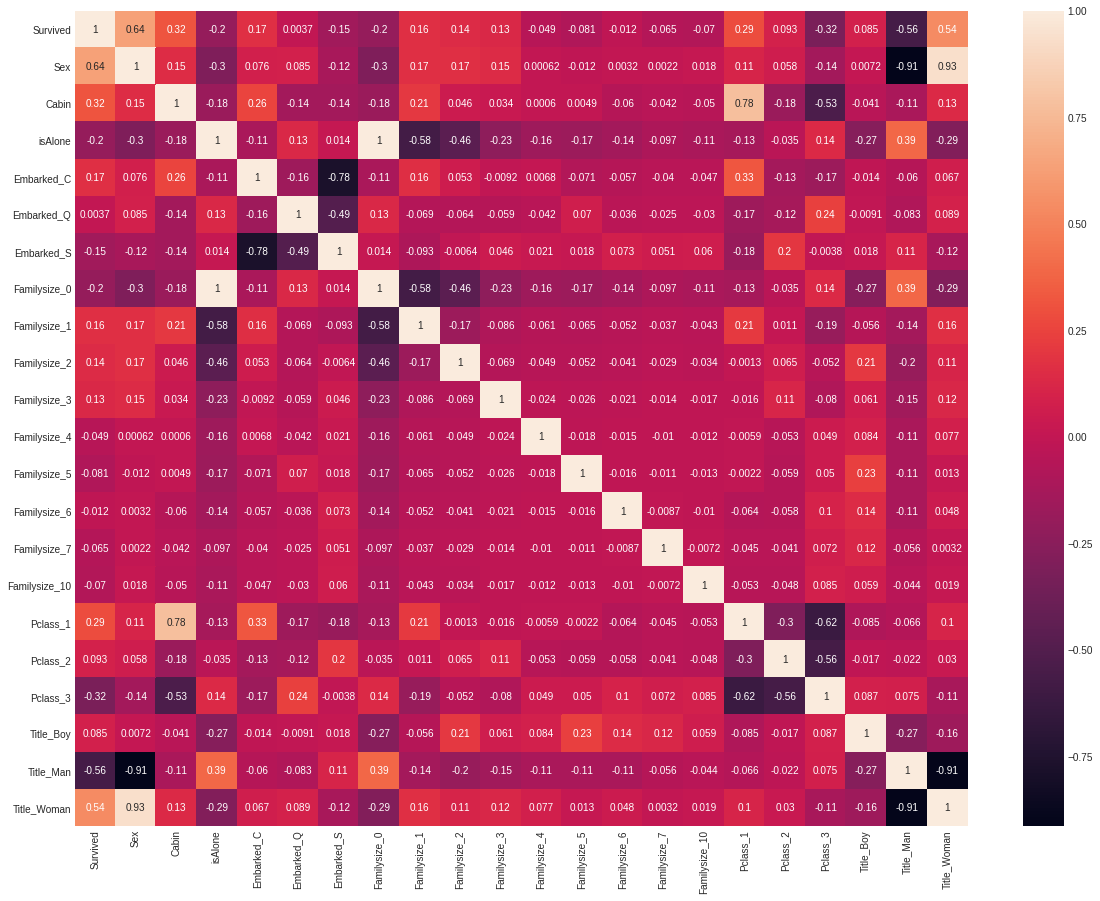

In [48]:
plt.figure(figsize=(20,15))
sns.heatmap(df_improve.corr(),annot=True)

In [49]:
imp_train = df_improve[df_improve.Survived.notnull()]
final_test = df_improve[df_improve.Survived.isnull()].iloc[:,1:]

In [50]:
X_train = imp_train.iloc[:,1:]
y_train = imp_train.iloc[:,0]

In [51]:
seed = 2020
np.random.seed(seed)

## 4.2 ANN

In [52]:
# Importing the Keras libraries and packages
import keras
from keras.models import Sequential
from keras.layers import Dense

# Initialising the ANN
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = round((X_train.shape[1]+1)/2), kernel_initializer = 'uniform', activation = 'relu', input_dim = X_train.shape[1]))

# Adding the second hidden layer
classifier.add(Dense(units = round((X_train.shape[1]+1)/2), kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Fitting the ANN to the Training set
fit = classifier.fit(X_train, y_train, batch_size = 10, epochs = 300)

Epoch 1/300
90/90 [==============================] - 0s 1ms/step - loss: 0.6798 - accuracy: 0.6162
Epoch 2/300
90/90 [==============================] - 0s 1ms/step - loss: 0.5721 - accuracy: 0.7172
Epoch 3/300
90/90 [==============================] - 0s 1ms/step - loss: 0.4875 - accuracy: 0.8114
Epoch 4/300
90/90 [==============================] - 0s 1ms/step - loss: 0.4438 - accuracy: 0.8395
Epoch 5/300
90/90 [==============================] - 0s 1ms/step - loss: 0.4207 - accuracy: 0.8339
Epoch 6/300
90/90 [==============================] - 0s 1ms/step - loss: 0.4081 - accuracy: 0.8406
Epoch 7/300
90/90 [==============================] - 0s 1ms/step - loss: 0.4037 - accuracy: 0.8384
Epoch 8/300
90/90 [==============================] - 0s 1ms/step - loss: 0.3976 - accuracy: 0.8373
Epoch 9/300
90/90 [==============================] - 0s 1ms/step - loss: 0.3928 - accuracy: 0.8373
Epoch 10/300
90/90 [==============================] - 0s 1ms/step - loss: 0.3917 - accuracy: 0.8361
Epoch 11/

### 画出loss和accuracy的变化

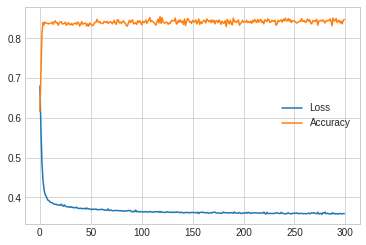

In [53]:
plt.plot(range(len(fit.history.get('loss'))),fit.history.get('loss'),label='Loss')
plt.plot(range(len(fit.history.get('accuracy'))),fit.history.get('accuracy'),label='Accuracy')
plt.legend()

# 5. 预测结果

In [54]:
# Predicting the Test set results
y_pred = classifier.predict(final_test)
y_pred = [0 if y<0.5 else 1 for y in y_pred]
y_pred = pd.DataFrame(y_pred)

result = pd.DataFrame({'PassengerId':df_test['PassengerId'].values, 'Survived':y_pred[0]})
result.to_csv("ANN-submission.csv", index=False)
result.head(10)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


# 6. 与其他模型得分对比

## 6.1 常用机器学习算法

### 特征缩放

In [55]:
# Machine learning 
import sklearn.ensemble as ske
from sklearn import datasets, model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier,ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier

# Grid and Random Search
from sklearn.model_selection import GridSearchCV,cross_val_score,StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

# Metrics
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc
#设置kfold，交叉采样法拆分数据集
kfold=StratifiedKFold(n_splits=10)

#汇总不同模型算法
classifiers=[]
classifiers.append(SVC())
classifiers.append(DecisionTreeClassifier())
classifiers.append(RandomForestClassifier())
classifiers.append(ExtraTreesClassifier())
classifiers.append(GradientBoostingClassifier())
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression())
classifiers.append(LGBMClassifier())
#不同机器学习交叉验证结果汇总
cv_results=[]
for classifiers in classifiers:
    cv_results.append(cross_val_score(classifiers,X_train,y_train,
                                      scoring='accuracy',cv=kfold,n_jobs=-1))

In [56]:
#求出模型得分的均值和标准差
cv_means=[]
cv_std=[]
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
    
#汇总数据
cvDf=pd.DataFrame({'cv_mean':cv_means,
                     'cv_std':cv_std,
                     'algorithm':['SVC','DecisionTreeCla','RandomForestCla','ExtraTreesCla',
                                  'GradientBoostingCla','KNN','LR','LGBMClassifier']})

cvDf = cvDf.sort_values('cv_mean',ascending=False)
cvDf

,cv_mean,cv_std,algorithm
6,0.830537,0.031099,LR
3,0.823833,0.033472,ExtraTreesCla
4,0.823808,0.037542,GradientBoostingCla
0,0.823795,0.030980,SVC
2,0.822697,0.034220,RandomForestCla
1,0.821586,0.032493,DecisionTreeCla
7,0.819326,0.034845,LGBMClassifier
5,0.809238,0.030298,KNN


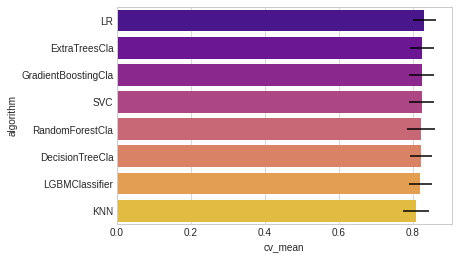

In [57]:
sns.barplot(data=cvDf,x='cv_mean',y='algorithm',**{'xerr':cv_std},palette='plasma')

*LR表现较好，然我们再选一个增强模型GBC进行对比。*

Fitting 10 folds for each of 216 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done 1576 tasks      | elapsed:   55.4s


0.8383520599250935 {'learning_rate': 0.5, 'loss': 'deviance', 'max_depth': 4, 'max_features': 0.3, 'min_samples_leaf': 150, 'n_estimators': 50}


[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed:  1.3min finished


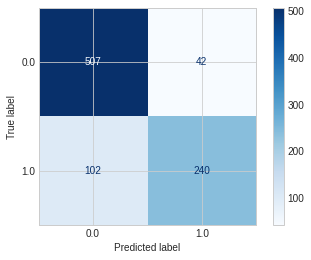

In [58]:
#GradientBoostingClassifier模型
GBC = GradientBoostingClassifier(random_state=seed)
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [50,100,200],
              'learning_rate': [0.5, 0.1, 0.05, 0.01],
              'max_depth': [4,8,16],
              'min_samples_leaf': [100,150,200],
              'max_features': [0.3, 0.1] 
              }
modelgsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold,
                                     scoring="accuracy", n_jobs= -1, verbose = 1)
modelgsGBC.fit(X_train,y_train)
modelgsGBC_accuracy = modelgsGBC.best_score_
modelgsGBC_parameters = modelgsGBC.best_params_

print(modelgsGBC_accuracy,modelgsGBC_parameters)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(modelgsGBC, X_train, y_train,
                                 cmap=plt.cm.Blues)

[LibLinear]

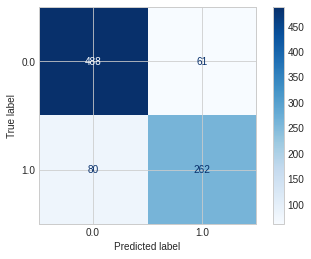

In [59]:
#train model
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=1.0,
                   class_weight=None,
                   dual=False, 
                   fit_intercept=True,
                   intercept_scaling=1, 
                   max_iter=100, 
                   multi_class='ovr',
                   n_jobs=-1,
                   penalty='l2',
                   random_state=seed, 
                   solver='liblinear',
                   tol=0.0001,
                   verbose=1, 
                   warm_start=False)
lr.fit(X_train, y_train)
disp2 = plot_confusion_matrix(lr, X_train, y_train,
                                 cmap=plt.cm.Blues)

### ROC曲线

Text(0.5, 1.0, 'ROC for Titanic survivors')

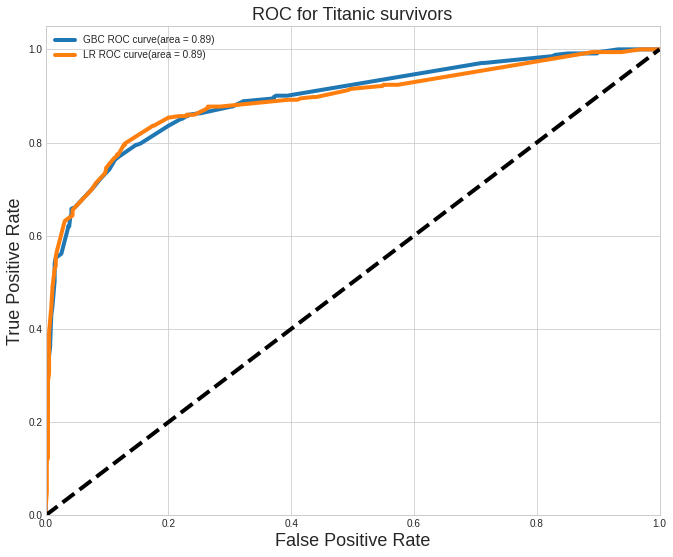

In [60]:
from sklearn.metrics import roc_curve, auc
#plt.style.use('seaborn-pastel')
y_score1 = modelgsGBC.predict_proba(X_train)[:,1]
y_score2 = lr.predict_proba(X_train)[:,1]
FPR1, TPR1, _ = roc_curve(y_train, y_score1)
FPR2, TPR2, _ = roc_curve(y_train, y_score2)

ROC_AUC1 = auc(FPR1, TPR1)
ROC_AUC2 = auc(FPR2, TPR2)

plt.figure(figsize =[11,9])
plt.plot(FPR1, TPR1, label= 'GBC ROC curve(area = %0.2f)'%ROC_AUC1, linewidth= 4)
plt.plot(FPR2, TPR2, label= 'LR ROC curve(area = %0.2f)'%ROC_AUC2, linewidth= 4)
plt.legend()
plt.plot([0,1],[0,1], 'k--', linewidth = 4)
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate', fontsize = 18)
plt.ylabel('True Positive Rate', fontsize = 18)
plt.title('ROC for Titanic survivors', fontsize= 18)

In [61]:
y_pred=lr.predict(final_test)
y_pred=y_pred.astype(int)

In [62]:
result = pd.DataFrame({'PassengerId':df_test['PassengerId'].values, 'Survived':y_pred})
result.to_csv("GBC-submission.csv", index=False)
print(result['Survived'].value_counts())
result.head(10)

0    259
1    159
Name: Survived, dtype: int64


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


## 6.1 此文预测结果得分

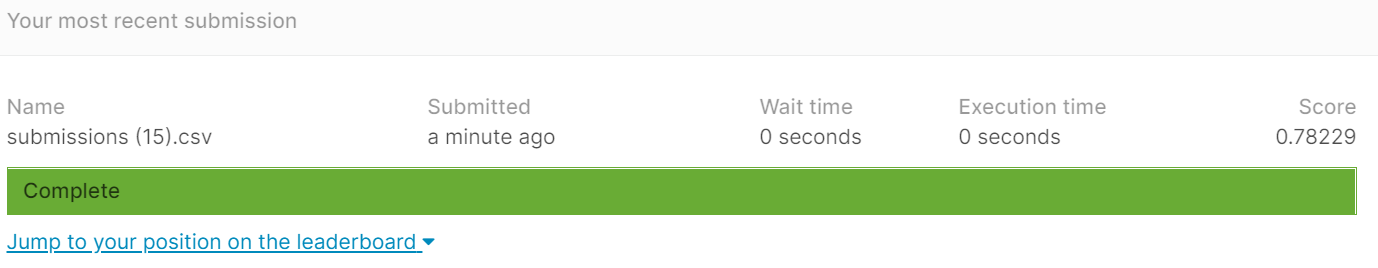

### 6.2 结论

### 1. 通过完成这个新手竞赛，在这个过程中，不断探索特征工程，不断对比特征，进行特征选取，还有模型上的选择，慢慢发现，特征不是越多越好，模型也不是准确度越高越好，一开始作为新手的我，就进入很大的一个误区，因为在学习ML的时候通常是训练集测试集都完整的情况下，过拟合可以很容易被发现，但是竞赛中，测试集的y是未知的，只能通过一次一次的对比LB分数，来对比。后来，看了各种大神的notebook，决定戒骄戒躁，一步一步的将特征工程一步一步堆上去，用学习曲线和roc去辅助慢慢做调整和对比，才慢慢有提升，以至于到后来，分数其实已经不重要了，这个学习的过程是最有意义的。
### 2. 最后，特征工程真的是太重要了，为什么这么说，同样的特征工程用不同的模型来预测，出来的结果不会有特别大的出入，调参，集成是会有一定提分，但是太局限了，而特征提取的好，可能只需要几列变量用最简单的LR模型也能得出不错的成绩，典型的就是cdeotte大佬的WCG模型，利用了lady child first这个当时一大逃生原则进行开展深挖。
### 3. Titanic: Machine Learning from Disaster是kaggle很适合新手学习机器学习/深度学习的一个入门比赛，在实践这个项目的过程，可以通过notebook研究大神的特征工程、模型选择、提升、优化等的思路，以及discussion部分，关于这个竞赛的大部分问题讨论，可以帮助新手提升自己的技能以及逐步提高他们的得分

## Reference: 
1. https://zhuanlan.zhihu.com/p/50194676
2. https://www.kaggle.com/gunesevitan/titanic-advanced-feature-engineering-tutorial
3. https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python
4. https://www.kaggle.com/cdeotte/titanic-using-name-only-0-818184.